# Install and import dependencies

## Installation

The first step is to install all the necessary libraries. 

1. Machine Learning libraries:

**- TensorFlow:** For this project, I will use TensorFlow, and as I am using an Apple silicon Mac, I will be running TensorFlow in the Metal API. 

**- Scikit-Learn:** This library is leveraged to split training and testing data and to quantify the precision or the likelihood of the speaker expressing a word on the real-time video feed.

2. Computer Vision libraries:

**- OpenCV** is an open-source Computer Vision library, in this project it is used to enable webcam activation.
**- MediaPipe Holistic** is used to track hand and face features by extracting keypoints.

3. Plotting library:

**- Matplotlib** is used for visual representation of data.

In [1]:
!pip install tensorflow tensorflow-metal opencv-python mediapipe scikit-learn matplotlib

Installation test for MacOS; the following code is a test to see if tensorflow is installed correclty and if it runs smoothly on the Metal API.

In [2]:
import tensorflow as tf

cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=100,)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=64)

2024-03-22 15:01:25.126625: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-03-22 15:01:25.126654: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-03-22 15:01:25.126660: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-03-22 15:01:25.126721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-22 15:01:25.126759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2024-03-22 15:01:28.758884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 56s 66ms/step - loss: 4.7161 - accuracy: 0.0686
Epoch 2/5
782/782 [==============================] - 48s 61ms/step - loss: 3.9461 - accuracy: 0.1463
Epoch 3/5
782/782 [==============================] - 49s 62ms/step - loss: 3.8843 - accuracy: 0.1575
Epoch 4/5
782/782 [==============================] - 50s 64ms/step - loss: 3.5390 - accuracy: 0.1922
Epoch 5/5
782/782 [==============================] - 51s 65ms/step - loss: 3.2480 - accuracy: 0.2401


## Import

In [10]:
import cv2                                  # Import OpenCV
import numpy as np                          # Import NumPy to help structure arrays (datasets)
import os                                   # To easier work with filepaths
from matplotlib import pyplot as plt        # Import pyplot from Matplotlib
import time                                 # Import time
import mediapipe as mp                      # Import MediaPipe

# Access to webcam using OpenCV and keypoints detection using MediaPipe

In [11]:
# Holistic model to make detection
mp_holistic = mp.solutions.holistic 

# Drawing utilities to draw detection
mp_drawing = mp.solutions.drawing_utils 

In [12]:
# Function to make the detection
def mediapipe_detection(image, model):
    # Convert colors from BGR to RGB (needs to be RGB to make detection in MediaPipe)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # To save space --> make unwriteable image
    image.flags.writeable = False  
    # Make prediction
    results = model.process(image) 
    # Convert back to writeable image
    image.flags.writeable = True  
    # Convert colors from BGR to RGB                 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [34]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(236,138,26), thickness=1, circle_radius=1),  # dot color (remember colors are in BGR )  
                             mp_drawing.DrawingSpec(color=(236,208,26), thickness=1, circle_radius=1)   # line color
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(186,52,25), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(236,103,26), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,153,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(51,255,51), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,255,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,102), thickness=2, circle_radius=2)
                             ) 

In [35]:
# Access webcam (video capture device 0 should be the webcam)
cap = cv2.VideoCapture(0)

# Set MediaPipe model 
# What MediaPipe initially does is it detects the keypoints and then tracks
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through the camera
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read() # return value and frame
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        # Draw landmarks
        draw_landmarks(image, results)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        # Break out of the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):  # if 'q' is hit in keyboard
            break
        
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1711143203.117419       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Max


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

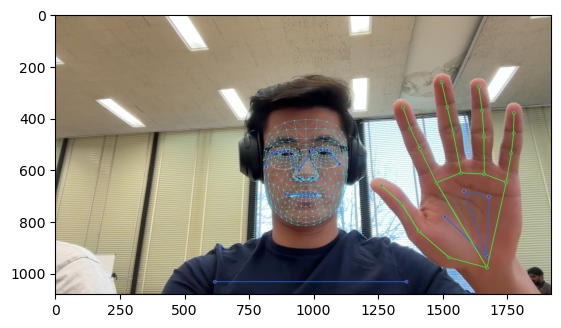

In [36]:
# We have access to the last frame
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

Extract keypoints values into a NumPy array. If no results are gotten in a frame (instance), there will be incompatibility issues as the array will not have the same size. In those cases, a NumPy array of zeros with the same size is leveraged.

In [37]:
len(results.left_hand_landmarks.landmark)

21

In [40]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)